### Data analysis

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt

In [2]:
DATA_PATH = "./trafic_32"
device = torch.device("cuda")
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )

dataset = torchvision.datasets.ImageFolder(DATA_PATH, transform=transform)
batch_size = 32
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

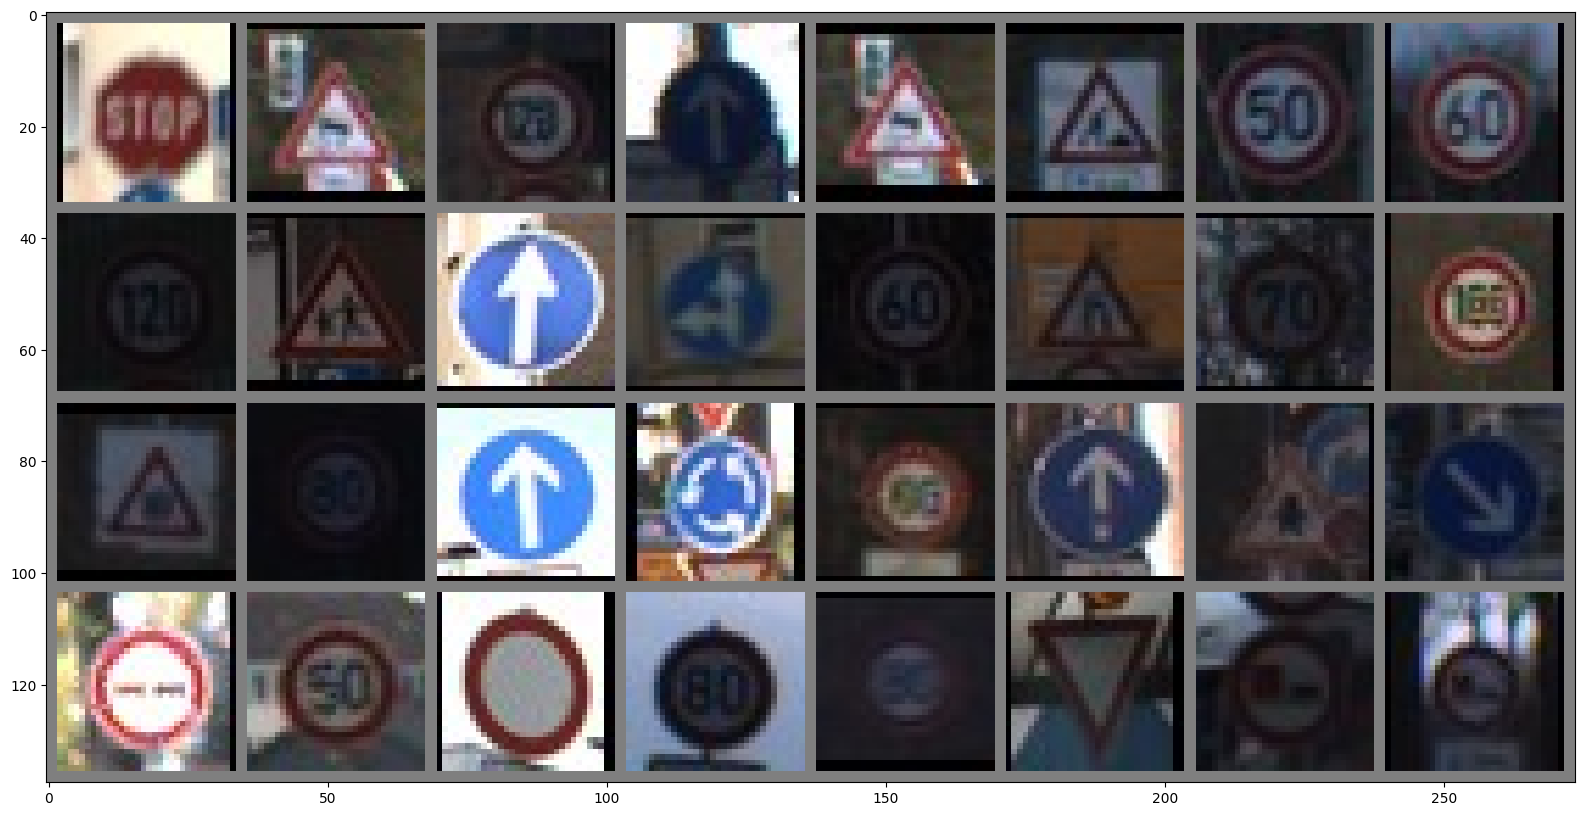

torch.Size([3, 32, 32])


In [3]:
plt.figure(figsize = (20,10))

# get some random training images
images, labels = next(iter(dataloader))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# image shape
print(images[0].shape)

In [4]:
from diffusion import forward_diffusion

transform = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
        ]
    )

reverse_transform = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])


dataset_diff = torchvision.datasets.ImageFolder(DATA_PATH, transform=transform)
batch_size_diff = 128
dataloader_diff = torch.utils.data.DataLoader(dataset_diff, batch_size=batch_size_diff, shuffle=True)

image = next(iter(dataloader_diff))[0]

num_images = 10
steps = 200
stepsize = int(steps/num_images)


def get_noisy_image(x_start, t):
  # add noise
  x_noisy, _ = forward_diffusion(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image


In [5]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [6]:
x_start = image[0].unsqueeze(0)
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 10, 20, 30, 40]])